# Parameters

In [1]:
data_dir = './data/'
nodes = [100, 200, 200, 200]  # Nodes in hidden layers, default [100,200,200,200]
device = 'cuda:1'  # Device to use by pytorch, default cuda:1
epochs = 100  # Epochs in Pytorch, default 100

# Load data

In [2]:
import pandas as pd

# data_path = data_dir + "train2_norm_sampled_10k.pkl"  # 10k
# data_path = data_dir + "train2_norm_sampled_100k.pkl"  # 100k
# data_path = data_dir + "train2_norm_sampled_1M.pkl"  # 1M
# data_path = data_dir + "train2_norm_sampled.pkl"  # 3.09M, upsampled & downsampled, 3.090,617 samples
# data_path = data_dir + "train2_norm_resampled.pkl"  # all upsampled without downsampling

# df_train = df_test = pd.read_pickle(data_path)

# df_train = pd.read_pickle(data_dir + "train2_norm_sampled_test_0.05.pkl")
df_train = pd.read_pickle(data_dir + "train2_norm_sampled_train_0.95.pkl")
df_test = pd.read_pickle(data_dir + "train2_norm_sampled_test_0.05.pkl")

In [3]:
import torch
from torch.autograd import Variable

X_train = torch.tensor(df_train[["CO+CO2", "H*", "O*", "C*"]].values, device=device)
y_train = torch.tensor(df_train[["n2_out"+ f"{v}" for v in range(1, 51)]].values, device=device)
X_test = torch.tensor(df_test[["CO+CO2", "H*", "O*", "C*"]].values, device=device)
y_test = torch.tensor(df_test[["n2_out"+ f"{v}" for v in range(1, 51)]].values, device=device)

print(f"Num of training samples: {len(X_train)}, num of testing samples {len(X_test)}")

Num of training samples: 2615048, num of testing samples 137635


In [4]:
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline


def plot_3d_subplot(x, y, savepath):
    '''
     x,y type: numpy 2darray
    '''
    fig = plt.figure(figsize=(20, 10))
    xline, yline, zline1, zline2 = x[:, 0], x[:, 1], y[:, 0], y[:, 1]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('CO+CO2', fontsize=10)
    ax1.set_ylabel('N2', fontsize=10)
    ax1.set_zlabel('W1', fontsize=10)
    ax1.scatter3D(xline, yline, zline1, c=zline1, cmap=cm.coolwarm)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_xlabel('CO+CO2', fontsize=10)
    ax2.set_ylabel('N2', fontsize=10)
    ax2.set_zlabel('W2', fontsize=10)
    ax2.scatter3D(xline, yline, zline2, c=zline2, cmap=cm.coolwarm)

    #plt.savefig(savepath)

Start time = 2021-12-02 12:04:33.148287
End time = 2021-12-02 12:04:33.277962


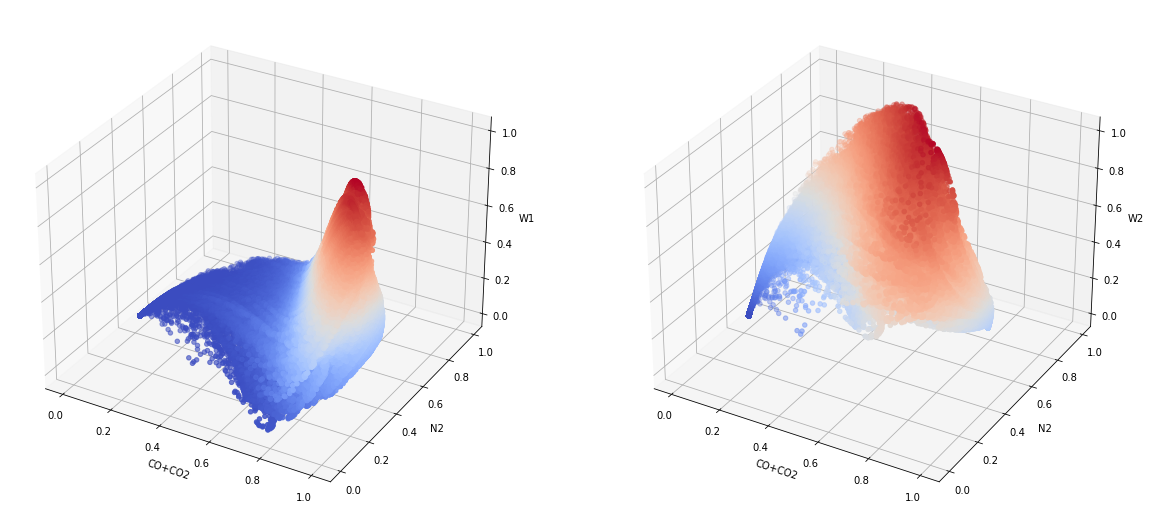

In [5]:
import datetime

print(f"Start time = {datetime.datetime.now()}")
plot_3d_subplot(X_test[:, :2].cpu().data.numpy(), y_test.cpu().data.numpy(), f"result/3D_plot-ann2-W-target.png")
print(f"End time = {datetime.datetime.now()}")

# Create model
## Create a new model
### Simple fully-connected 5 layer model

In [6]:
def create_model(n_input, n_output, nodes, device='cpu'):
    modules = []

    # add first hidden layer (and input layer)
    modules.append(torch.nn.Linear(n_input, nodes[0]))
    modules.append(torch.nn.LeakyReLU())

    for i in range(1, len(nodes)):
        modules.append(torch.nn.Linear(nodes[i-1], nodes[i]))
        modules.append(torch.nn.LeakyReLU())

    # add output layer
    modules.append(torch.nn.Linear(nodes[-1], n_output))

    model = torch.nn.Sequential(*modules).to(device)

    return model

In [7]:
model = create_model(X_train.shape[1], y_train.shape[1], nodes, device=device)

### ResNet model

In [8]:
import torch.nn as nn


class ResBlock(nn.Module):
    def __init__(self, n_input=100, n_res_nodes=100, device='cpu'):
        super(ResBlock, self).__init__()
        self.linear1 = nn.Linear(n_input, n_res_nodes)
        self.lrelu1 = nn.LeakyReLU()

        self.linear2 = nn.Linear(n_res_nodes, n_input)
        self.lrelu2 = nn.LeakyReLU()

    def forward(self, x):
        residual = x
        out = self.lrelu1(self.linear1(x))
        out = self.linear2(out)
        out = self.lrelu2(residual + out)
        return out

In [9]:
def create_model(n_input, n_output, n_res_layer=4, n_res_input=100, n_res_nodes=100, device='cpu'):
    modules = []

    # add first hidden layer (and input layer)
    modules.append(torch.nn.Linear(n_input, n_res_input))
    modules.append(torch.nn.LeakyReLU())

    for i in range(n_res_layer):
        modules.append(ResBlock(n_res_input, n_res_nodes))

    # add output layer
    modules.append(torch.nn.Linear(n_res_input, n_output))

    model = torch.nn.Sequential(*modules).to(device)

    return model

In [10]:
model = create_model(X_train.shape[1], y_train.shape[1], n_res_layer=4,
                     n_res_input=200, n_res_nodes=200, device=device)

## Save model

In [11]:
def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)

## Load pretrained model

In [12]:
def load_model(X_train, y_train, nodes, device, model_path):
    model = create_model(X_train.shape[1], y_train.shape[1], nodes, device=device)
    model.load_state_dict(torch.load(model_path))
    return model.eval()

In [13]:
# model = load_model(X_train.shape[1], y_train.shape[1], nodes, device=device, model_path)

# Model training

In [14]:
n_epoch = 1000
lr = 0.001  # 0.001
lr_decay = 0.96
momentum = 0.9
BATCH_SIZE = 128
save_path = './'
eval_interval = 1

## Define dataloader

In [15]:
import torch.utils.data as Data

# Process training data
torch.manual_seed(1)    # reproducible
train_dataset = Data.TensorDataset(X_train, y_train)
loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False, )

## Set optimizer

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # only works with mean, not sum, loss 
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)  # lr*gamma^step

## Define loss

In [17]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor


class FlameLoss(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'sum') -> None:
        super(FlameLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return torch.sum((target + 1) * (input - target) ** 2)

## Train model

In [18]:
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)

# logging.basicConfig(filename='./ann2_models/train.log', filemode='w',
#                         format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
logging.info("message")

2021-12-02 12:04:36,487 INFO: message


In [ ]:
import numpy as np

loss_values = []
best_loss = float('inf')

for epoch in range(n_epoch):
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x).to(device)
        b_y = Variable(batch_y).to(device)

        y_pred = model(b_x.float())
        loss = torch.nn.MSELoss(reduction='mean')(y_pred, b_y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % eval_interval == 0:
        # evaluate model every $eval_interval$ steps
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test.float())
            e_loss = torch.nn.MSELoss(reduction='mean')(y_pred, y_test.float())
            loss_values.append(e_loss.cpu())

            y_err = (y_pred-y_test).cpu().data.numpy()
            y_abs_err = np.abs(y_err).max(axis=0)
            logging.info(f"epoch {epoch+1}: Train loss={loss:.4f}, Eval loss={e_loss:.4f}, Max_err={max(y_abs_err):.4f}, M1_err={y_abs_err[0]:.4f}, M2_err={y_abs_err[1]:.4f}")
            if e_loss < best_loss:
                best_loss = e_loss
                save_model(model, save_path + f"model_{epoch+1}_{e_loss:.4f}.pt")

        model.train()
    # lr_scheduler.step()

save_model(model, save_path + f"model_final_{loss:.4f}.pt")
print(f"Final epoch loss={e_loss}")

fig = plt.figure(figsize=(10, 10))
plt.plot(loss_values)

2021-12-02 12:05:54,686 INFO: epoch 1: Train loss=0.0176, Eval loss=0.0112, Max_err=0.8324, M1_err=0.4486, M2_err=0.2979
2021-12-02 12:07:12,919 INFO: epoch 2: Train loss=0.0077, Eval loss=0.0069, Max_err=0.8128, M1_err=0.3743, M2_err=0.1988
2021-12-02 12:08:31,173 INFO: epoch 3: Train loss=0.0031, Eval loss=0.0051, Max_err=0.7903, M1_err=0.3452, M2_err=0.1957
2021-12-02 12:09:48,950 INFO: epoch 4: Train loss=0.0038, Eval loss=0.0039, Max_err=0.7766, M1_err=0.3203, M2_err=0.1902
2021-12-02 12:11:07,507 INFO: epoch 5: Train loss=0.0036, Eval loss=0.0032, Max_err=0.7635, M1_err=0.3042, M2_err=0.1816


2 M dataset

2. ResNet + SGD + Momentum 0.9
```
2021-12-02 12:05:54,686 INFO: epoch 1: Train loss=0.0176, Eval loss=0.0112, Max_err=0.8324, M1_err=0.4486, M2_err=0.2979
2 M dataset
```


1. FCN + Adam + lr_decay
```
2021-11-27 23:17:30,695 INFO: epoch 1: Train loss=0.0039, Eval loss=0.0026, Max_err=0.6936, M1_err=0.2482, M2_err=0.3298
2021-11-27 23:18:38,958 INFO: epoch 2: Train loss=0.0031, Eval loss=0.0044, Max_err=0.8406, M1_err=0.3033, M2_err=0.2754
2021-11-27 23:19:52,883 INFO: epoch 3: Train loss=0.0050, Eval loss=0.0043, Max_err=0.7993, M1_err=0.3141, M2_err=0.2365
2021-11-27 23:21:04,844 INFO: epoch 4: Train loss=0.0038, Eval loss=0.0060, Max_err=0.8346, M1_err=0.3208, M2_err=0.2007
2021-11-27 23:22:15,304 INFO: epoch 5: Train loss=0.0019, Eval loss=0.0030, Max_err=0.8315, M1_err=0.2423, M2_err=0.2843
2021-11-27 23:23:31,184 INFO: epoch 6: Train loss=0.0045, Eval loss=0.0055, Max_err=0.7369, M1_err=0.3368, M2_err=0.2131
2021-11-27 23:24:52,619 INFO: epoch 7: Train loss=0.0052, Eval loss=0.0075, Max_err=0.8074, M1_err=0.4262, M2_err=0.2451
2021-11-27 23:26:05,440 INFO: epoch 8: Train loss=0.0041, Eval loss=0.0041, Max_err=0.8641, M1_err=0.2922, M2_err=0.2757
2021-11-27 23:27:20,339 INFO: epoch 9: Train loss=0.0059, Eval loss=0.0040, Max_err=0.8105, M1_err=0.3398, M2_err=0.2147
2021-11-27 23:28:38,816 INFO: epoch 10: Train loss=0.0020, Eval loss=0.0026, Max_err=0.6635, M1_err=0.2894, M2_err=0.1810
2021-11-27 23:29:57,932 INFO: epoch 11: Train loss=0.0010, Eval loss=0.0020, Max_err=0.6871, M1_err=0.2997, M2_err=0.2276
2021-11-27 23:31:13,170 INFO: epoch 12: Train loss=0.0065, Eval loss=0.0039, Max_err=0.7329, M1_err=0.2859, M2_err=0.2054
2021-11-27 23:32:30,572 INFO: epoch 13: Train loss=0.0112, Eval loss=0.0140, Max_err=0.8581, M1_err=0.3994, M2_err=0.4225
2021-11-27 23:33:48,501 INFO: epoch 14: Train loss=0.0198, Eval loss=0.0153, Max_err=0.8268, M1_err=0.4195, M2_err=0.3339
2021-11-27 23:35:07,341 INFO: epoch 15: Train loss=0.0048, Eval loss=0.0044, Max_err=0.7850, M1_err=0.3118, M2_err=0.1706
2021-11-27 23:36:23,662 INFO: epoch 16: Train loss=0.0047, Eval loss=0.0059, Max_err=0.7893, M1_err=0.3638, M2_err=0.2442
2021-11-27 23:37:40,714 INFO: epoch 17: Train loss=0.0092, Eval loss=0.0105, Max_err=0.8443, M1_err=0.3140, M2_err=0.3187
2021-11-27 23:38:59,201 INFO: epoch 18: Train loss=0.0019, Eval loss=0.0029, Max_err=1.0612, M1_err=0.4421, M2_err=0.3244
2021-11-27 23:40:19,095 INFO: epoch 19: Train loss=0.0074, Eval loss=0.0030, Max_err=0.7298, M1_err=0.3128, M2_err=0.2302
2021-11-27 23:41:32,493 INFO: epoch 20: Train loss=0.0050, Eval loss=0.0041, Max_err=0.7292, M1_err=0.2984, M2_err=0.2196
2021-11-27 23:42:48,563 INFO: epoch 21: Train loss=0.0017, Eval loss=0.0020, Max_err=0.6543, M1_err=0.2234, M2_err=0.1847
2021-11-27 23:44:05,519 INFO: epoch 22: Train loss=0.0050, Eval loss=0.0034, Max_err=0.7991, M1_err=0.2766, M2_err=0.2107
2021-11-27 23:45:24,814 INFO: epoch 23: Train loss=0.0036, Eval loss=0.0040, Max_err=0.7218, M1_err=0.2746, M2_err=0.1779
2021-11-27 23:46:43,945 INFO: epoch 24: Train loss=0.0053, Eval loss=0.0085, Max_err=1.5966, M1_err=0.4719, M2_err=0.4041
2021-11-27 23:48:01,228 INFO: epoch 25: Train loss=0.0038, Eval loss=0.0025, Max_err=0.6939, M1_err=0.2305, M2_err=0.2139
2021-11-27 23:49:20,058 INFO: epoch 26: Train loss=0.0009, Eval loss=0.0020, Max_err=0.6459, M1_err=0.2149, M2_err=0.1613
2021-11-27 23:50:38,198 INFO: epoch 27: Train loss=0.0030, Eval loss=0.0024, Max_err=0.6441, M1_err=0.2877, M2_err=0.1632
2021-11-27 23:51:54,645 INFO: epoch 28: Train loss=0.0009, Eval loss=0.0019, Max_err=0.6760, M1_err=0.2670, M2_err=0.1883
2021-11-27 23:53:12,118 INFO: epoch 29: Train loss=0.0011, Eval loss=0.0026, Max_err=0.6911, M1_err=0.3249, M2_err=0.1741
2021-11-27 23:54:29,572 INFO: epoch 30: Train loss=0.0025, Eval loss=0.0031, Max_err=0.7128, M1_err=0.2935, M2_err=0.1938
2021-11-27 23:55:48,458 INFO: epoch 31: Train loss=0.0012, Eval loss=0.0037, Max_err=24.8941, M1_err=23.9950, M2_err=10.7935
2021-11-27 23:56:48,448 INFO: epoch 32: Train loss=0.0031, Eval loss=0.0024, Max_err=0.6271, M1_err=0.2600, M2_err=0.1724
2021-11-27 23:57:48,761 INFO: epoch 33: Train loss=0.0016, Eval loss=0.0019, Max_err=0.6589, M1_err=0.2287, M2_err=0.1596
2021-11-27 23:59:01,877 INFO: epoch 34: Train loss=0.0029, Eval loss=0.0034, Max_err=0.6867, M1_err=0.2427, M2_err=0.1822
2021-11-28 00:00:21,000 INFO: epoch 35: Train loss=0.0015, Eval loss=0.0017, Max_err=0.6480, M1_err=0.2352, M2_err=0.1994
2021-11-28 00:01:41,109 INFO: epoch 36: Train loss=0.0030, Eval loss=0.0019, Max_err=0.6596, M1_err=0.2338, M2_err=0.1632
2021-11-28 00:02:42,398 INFO: epoch 37: Train loss=0.0017, Eval loss=0.0023, Max_err=0.6860, M1_err=0.2347, M2_err=0.1862
2021-11-28 00:03:59,285 INFO: epoch 38: Train loss=0.0016, Eval loss=0.0025, Max_err=0.6404, M1_err=0.2466, M2_err=0.1677
2021-11-28 00:05:18,696 INFO: epoch 39: Train loss=0.0008, Eval loss=0.0021, Max_err=0.6267, M1_err=0.2621, M2_err=0.1542
2021-11-28 00:06:37,058 INFO: epoch 40: Train loss=0.0006, Eval loss=0.0017, Max_err=0.5788, M1_err=0.2350, M2_err=0.1486
2021-11-28 00:07:48,842 INFO: epoch 41: Train loss=0.0029, Eval loss=0.0017, Max_err=0.5964, M1_err=0.2448, M2_err=0.1590
2021-11-28 00:09:01,760 INFO: epoch 42: Train loss=0.0016, Eval loss=0.0024, Max_err=0.6970, M1_err=0.4285, M2_err=0.1594
2021-11-28 00:10:20,547 INFO: epoch 43: Train loss=0.0031, Eval loss=0.0045, Max_err=1.2183, M1_err=0.3036, M2_err=0.2326
2021-11-28 00:11:36,325 INFO: epoch 44: Train loss=0.0037, Eval loss=0.0019, Max_err=0.6142, M1_err=0.2292, M2_err=0.1471
2021-11-28 00:12:55,396 INFO: epoch 45: Train loss=0.0006, Eval loss=0.0017, Max_err=0.6112, M1_err=0.2272, M2_err=0.1462
2021-11-28 00:14:12,335 INFO: epoch 46: Train loss=0.0010, Eval loss=0.0017, Max_err=0.5936, M1_err=0.2245, M2_err=0.1608
2021-11-28 00:15:32,218 INFO: epoch 47: Train loss=0.0012, Eval loss=0.0017, Max_err=0.6304, M1_err=0.2487, M2_err=0.2041
2021-11-28 00:16:52,365 INFO: epoch 48: Train loss=0.0026, Eval loss=0.0022, Max_err=0.7230, M1_err=0.2778, M2_err=0.1904
2021-11-28 00:18:11,222 INFO: epoch 49: Train loss=0.0052, Eval loss=0.0016, Max_err=0.6144, M1_err=0.2052, M2_err=0.1363
2021-11-28 00:19:24,696 INFO: epoch 50: Train loss=0.0024, Eval loss=0.0015, Max_err=0.6185, M1_err=0.2504, M2_err=0.1407
2021-11-28 00:20:28,508 INFO: epoch 51: Train loss=0.0011, Eval loss=0.0015, Max_err=0.6194, M1_err=0.2417, M2_err=0.1503
2021-11-28 00:21:33,844 INFO: epoch 52: Train loss=0.0008, Eval loss=0.0015, Max_err=0.6362, M1_err=0.2465, M2_err=0.1409
2021-11-28 00:22:52,812 INFO: epoch 53: Train loss=0.0008, Eval loss=0.0014, Max_err=0.6290, M1_err=0.2486, M2_err=0.1401
2021-11-28 00:24:10,202 INFO: epoch 54: Train loss=0.0013, Eval loss=0.0016, Max_err=0.6324, M1_err=0.2524, M2_err=0.1412
2021-11-28 00:25:23,517 INFO: epoch 55: Train loss=0.0010, Eval loss=0.0015, Max_err=0.6032, M1_err=0.2506, M2_err=0.1413
2021-11-28 00:26:27,868 INFO: epoch 56: Train loss=0.0019, Eval loss=0.0017, Max_err=0.6230, M1_err=0.2532, M2_err=0.1501
2021-11-28 00:27:33,160 INFO: epoch 57: Train loss=0.0003, Eval loss=0.0014, Max_err=0.6118, M1_err=0.2474, M2_err=0.1400
2021-11-28 00:28:44,116 INFO: epoch 58: Train loss=0.0007, Eval loss=0.0014, Max_err=0.6187, M1_err=0.2468, M2_err=0.1349
2021-11-28 00:30:01,488 INFO: epoch 59: Train loss=0.0050, Eval loss=0.0015, Max_err=0.6096, M1_err=0.2594, M2_err=0.1432
2021-11-28 00:31:11,194 INFO: epoch 60: Train loss=0.0008, Eval loss=0.0014, Max_err=0.6296, M1_err=0.2284, M2_err=0.1368
2021-11-28 00:32:25,375 INFO: epoch 61: Train loss=0.0013, Eval loss=0.0019, Max_err=1.9842, M1_err=0.5189, M2_err=0.3846
2021-11-28 00:33:37,566 INFO: epoch 62: Train loss=0.0007, Eval loss=0.0014, Max_err=0.6286, M1_err=0.2334, M2_err=0.1717
2021-11-28 00:34:54,168 INFO: epoch 63: Train loss=0.0017, Eval loss=0.0017, Max_err=0.6221, M1_err=0.2869, M2_err=0.1861
2021-11-28 00:36:13,524 INFO: epoch 64: Train loss=0.0008, Eval loss=0.0014, Max_err=0.6190, M1_err=0.2513, M2_err=0.1568
2021-11-28 00:37:32,096 INFO: epoch 65: Train loss=0.0005, Eval loss=0.0013, Max_err=0.6232, M1_err=0.2403, M2_err=0.1355
2021-11-28 00:38:52,375 INFO: epoch 66: Train loss=0.0006, Eval loss=0.0013, Max_err=0.6226, M1_err=0.2352, M2_err=0.1340
2021-11-28 00:40:09,276 INFO: epoch 67: Train loss=0.0011, Eval loss=0.0013, Max_err=0.6164, M1_err=0.2386, M2_err=0.1425
2021-11-28 00:41:17,530 INFO: epoch 68: Train loss=0.0008, Eval loss=0.0013, Max_err=0.6241, M1_err=0.2426, M2_err=0.1657
2021-11-28 00:42:26,889 INFO: epoch 69: Train loss=0.0018, Eval loss=0.0013, Max_err=0.6280, M1_err=0.2370, M2_err=0.1594
2021-11-28 00:43:43,149 INFO: epoch 70: Train loss=0.0008, Eval loss=0.0013, Max_err=0.6370, M1_err=0.2406, M2_err=0.1535
2021-11-28 00:45:00,293 INFO: epoch 71: Train loss=0.0014, Eval loss=0.0027, Max_err=1.2492, M1_err=0.3256, M2_err=0.2968
2021-11-28 00:46:17,847 INFO: epoch 72: Train loss=0.0015, Eval loss=0.0013, Max_err=0.6354, M1_err=0.2436, M2_err=0.1508
2021-11-28 00:47:37,526 INFO: epoch 73: Train loss=0.0007, Eval loss=0.0013, Max_err=0.6442, M1_err=0.2351, M2_err=0.1257
2021-11-28 00:48:53,378 INFO: epoch 74: Train loss=0.0006, Eval loss=0.0012, Max_err=0.6222, M1_err=0.2357, M2_err=0.1279
2021-11-28 00:50:11,571 INFO: epoch 75: Train loss=0.0004, Eval loss=0.0012, Max_err=0.6279, M1_err=0.2331, M2_err=0.1275
2021-11-28 00:51:22,387 INFO: epoch 76: Train loss=0.0013, Eval loss=0.0012, Max_err=0.6262, M1_err=0.2393, M2_err=0.1270
2021-11-28 00:52:27,190 INFO: epoch 77: Train loss=0.0032, Eval loss=0.0014, Max_err=0.9039, M1_err=0.3706, M2_err=0.3243
2021-11-28 00:53:33,480 INFO: epoch 78: Train loss=0.0007, Eval loss=0.0012, Max_err=0.6189, M1_err=0.2391, M2_err=0.1259
2021-11-28 00:54:45,583 INFO: epoch 79: Train loss=0.0036, Eval loss=0.0012, Max_err=0.6139, M1_err=0.2439, M2_err=0.1431
2021-11-28 00:55:48,632 INFO: epoch 80: Train loss=0.0004, Eval loss=0.0012, Max_err=0.6148, M1_err=0.2385, M2_err=0.1310
2021-11-28 00:57:06,806 INFO: epoch 81: Train loss=0.0003, Eval loss=0.0012, Max_err=0.6153, M1_err=0.2415, M2_err=0.1434
2021-11-28 00:58:22,618 INFO: epoch 82: Train loss=0.0020, Eval loss=0.0012, Max_err=0.6125, M1_err=0.2358, M2_err=0.1385
2021-11-28 00:59:39,805 INFO: epoch 83: Train loss=0.0005, Eval loss=0.0012, Max_err=0.6134, M1_err=0.2374, M2_err=0.1437
2021-11-28 01:00:51,996 INFO: epoch 84: Train loss=0.0011, Eval loss=0.0012, Max_err=0.6063, M1_err=0.2372, M2_err=0.1429
2021-11-28 01:01:55,184 INFO: epoch 85: Train loss=0.0001, Eval loss=0.0012, Max_err=0.6108, M1_err=0.2405, M2_err=0.1458
2021-11-28 01:03:07,418 INFO: epoch 86: Train loss=0.0015, Eval loss=0.0012, Max_err=0.6136, M1_err=0.2351, M2_err=0.1410
2021-11-28 01:04:23,274 INFO: epoch 87: Train loss=0.0007, Eval loss=0.0012, Max_err=0.6083, M1_err=0.2378, M2_err=0.1441
2021-11-28 01:05:40,550 INFO: epoch 88: Train loss=0.0019, Eval loss=0.0012, Max_err=0.6099, M1_err=0.2494, M2_err=0.2271
2021-11-28 01:06:57,178 INFO: epoch 89: Train loss=0.0016, Eval loss=0.0012, Max_err=0.6153, M1_err=0.2449, M2_err=0.1676
2021-11-28 01:08:15,669 INFO: epoch 90: Train loss=0.0006, Eval loss=0.0011, Max_err=0.6098, M1_err=0.2393, M2_err=0.1691
2021-11-28 01:09:34,074 INFO: epoch 91: Train loss=0.0005, Eval loss=0.0011, Max_err=0.6105, M1_err=0.2358, M2_err=0.1811
2021-11-28 01:10:49,419 INFO: epoch 92: Train loss=0.0028, Eval loss=0.0012, Max_err=0.5991, M1_err=0.2382, M2_err=0.1738
2021-11-28 01:12:04,835 INFO: epoch 93: Train loss=0.0005, Eval loss=0.0012, Max_err=0.6108, M1_err=0.2336, M2_err=0.2308
2021-11-28 01:13:22,014 INFO: epoch 94: Train loss=0.0005, Eval loss=0.0011, Max_err=0.6040, M1_err=0.2293, M2_err=0.1469
2021-11-28 01:14:38,907 INFO: epoch 95: Train loss=0.0007, Eval loss=0.0011, Max_err=0.6024, M1_err=0.2288, M2_err=0.2495
2021-11-28 01:15:54,536 INFO: epoch 96: Train loss=0.0012, Eval loss=0.0011, Max_err=0.5992, M1_err=0.2289, M2_err=0.1474
2021-11-28 01:16:57,684 INFO: epoch 97: Train loss=0.0007, Eval loss=0.0011, Max_err=0.5950, M1_err=0.2368, M2_err=0.1731
2021-11-28 01:18:00,076 INFO: epoch 98: Train loss=0.0006, Eval loss=0.0011, Max_err=0.6081, M1_err=0.2402, M2_err=0.1400
2021-11-28 01:19:12,994 INFO: epoch 99: Train loss=0.0030, Eval loss=0.0011, Max_err=0.6040, M1_err=0.2439, M2_err=0.1520
2021-11-28 01:20:30,988 INFO: epoch 100: Train loss=0.0016, Eval loss=0.0011, Max_err=0.6125, M1_err=0.2435, M2_err=0.1430
```

10k dataset
1. FCN without batchnorm
```
2021-12-02 11:47:06,267 INFO: epoch 1: Train loss=0.0049, Eval loss=0.0058, Max_err=0.7511, M1_err=0.4061, M2_err=0.2416
2021-12-02 11:47:06,496 INFO: epoch 2: Train loss=0.0057, Eval loss=0.0036, Max_err=0.6829, M1_err=0.2995, M2_err=0.2246
2021-12-02 11:47:06,723 INFO: epoch 3: Train loss=0.0032, Eval loss=0.0031, Max_err=0.7034, M1_err=0.2343, M2_err=0.2738
2021-12-02 11:47:06,951 INFO: epoch 4: Train loss=0.0016, Eval loss=0.0025, Max_err=0.6802, M1_err=0.2433, M2_err=0.1872
2021-12-02 11:47:07,178 INFO: epoch 5: Train loss=0.0013, Eval loss=0.0026, Max_err=0.7236, M1_err=0.2457, M2_err=0.1619
2021-12-02 11:47:07,435 INFO: epoch 6: Train loss=0.0022, Eval loss=0.0043, Max_err=0.7373, M1_err=0.3460, M2_err=0.1672
2021-12-02 11:47:07,693 INFO: epoch 7: Train loss=0.0020, Eval loss=0.0019, Max_err=0.6573, M1_err=0.2103, M2_err=0.1724
2021-12-02 11:47:07,918 INFO: epoch 8: Train loss=0.0030, Eval loss=0.0030, Max_err=0.7386, M1_err=0.2995, M2_err=0.1731
2021-12-02 11:47:08,142 INFO: epoch 9: Train loss=0.0039, Eval loss=0.0020, Max_err=0.6695, M1_err=0.2349, M2_err=0.1485
2021-12-02 11:47:08,369 INFO: epoch 10: Train loss=0.0010, Eval loss=0.0016, Max_err=0.6333, M1_err=0.1997, M2_err=0.1391
```
2. FCN with batchnorm -- significant drop in performance
```
2021-12-02 11:51:16,455 INFO: epoch 1: Train loss=0.2319, Eval loss=0.2548, Max_err=2.8119, M1_err=1.2965, M2_err=1.6304
2021-12-02 11:51:16,737 INFO: epoch 2: Train loss=0.2315, Eval loss=0.2470, Max_err=2.9610, M1_err=1.4907, M2_err=1.8753
2021-12-02 11:51:17,016 INFO: epoch 3: Train loss=0.2781, Eval loss=0.2545, Max_err=3.0300, M1_err=1.5212, M2_err=1.8768
2021-12-02 11:51:17,296 INFO: epoch 4: Train loss=0.2713, Eval loss=0.2539, Max_err=3.0367, M1_err=1.4877, M2_err=1.8532
2021-12-02 11:51:17,567 INFO: epoch 5: Train loss=0.2435, Eval loss=0.2497, Max_err=2.9543, M1_err=1.4956, M2_err=1.9678
2021-12-02 11:51:17,843 INFO: epoch 6: Train loss=0.2654, Eval loss=0.2539, Max_err=3.0876, M1_err=1.4464, M2_err=1.7841
2021-12-02 11:51:18,117 INFO: epoch 7: Train loss=0.2503, Eval loss=0.2496, Max_err=3.0299, M1_err=1.5120, M2_err=1.9358
2021-12-02 11:51:18,393 INFO: epoch 8: Train loss=0.2671, Eval loss=0.2492, Max_err=2.9884, M1_err=1.4659, M2_err=1.9428
2021-12-02 11:51:18,669 INFO: epoch 9: Train loss=0.2248, Eval loss=0.2447, Max_err=2.9184, M1_err=1.4476, M2_err=1.9357
2021-12-02 11:51:18,946 INFO: epoch 10: Train loss=0.2325, Eval loss=0.2517, Max_err=2.9650, M1_err=1.5244, M2_err=2.0980
```
3. ResNet without batchnorm -- max err droped
```
2021-12-02 12:01:11,985 INFO: epoch 1: Train loss=0.0051, Eval loss=0.0064, Max_err=0.8054, M1_err=0.3893, M2_err=0.2729
2021-12-02 12:01:12,346 INFO: epoch 2: Train loss=0.0061, Eval loss=0.0037, Max_err=0.6870, M1_err=0.2960, M2_err=0.2056
2021-12-02 12:01:12,711 INFO: epoch 3: Train loss=0.0032, Eval loss=0.0032, Max_err=0.6679, M1_err=0.2904, M2_err=0.2039
2021-12-02 12:01:13,080 INFO: epoch 4: Train loss=0.0012, Eval loss=0.0026, Max_err=0.7066, M1_err=0.2889, M2_err=0.1990
2021-12-02 12:01:13,467 INFO: epoch 5: Train loss=0.0005, Eval loss=0.0025, Max_err=0.7124, M1_err=0.2447, M2_err=0.1639
2021-12-02 12:01:13,849 INFO: epoch 6: Train loss=0.0027, Eval loss=0.0028, Max_err=0.6981, M1_err=0.2481, M2_err=0.1338
2021-12-02 12:01:14,231 INFO: epoch 7: Train loss=0.0030, Eval loss=0.0030, Max_err=0.6288, M1_err=0.2837, M2_err=0.2512
2021-12-02 12:01:14,614 INFO: epoch 8: Train loss=0.0026, Eval loss=0.0021, Max_err=0.6640, M1_err=0.1869, M2_err=0.1896
2021-12-02 12:01:14,998 INFO: epoch 9: Train loss=0.0039, Eval loss=0.0025, Max_err=0.6922, M1_err=0.2801, M2_err=0.1393
2021-12-02 12:01:15,381 INFO: epoch 10: Train loss=0.0018, Eval loss=0.0021, Max_err=0.6198, M1_err=0.2034, M2_err=0.1405
```

In [ ]:
import numpy as np

# np.savetxt(f"", loss_values, delimiter =", ", fmt='%s')

In [ ]:
plot_3d_subplot(X_test[:, :2].cpu().data.numpy(), y_pred.cpu().data.numpy(), f"result/flame2-ann2-loss={e_loss:.6f}.png")

In [ ]:
plot_3d_subplot(X_test[:, :2].cpu().data.numpy(), y_err, f"result/flame2-ann2-err-loss={e_loss:.6f}.png")

In [ ]:
std_err = np.abs(y_err).max(axis=0)

In [ ]:
print("loss value\tMax err\tW1 err\tW2 err\tRelative loss")
print(f"{e_loss}\t{max(std_err)}\t{std_err[0]}\t{std_err[1]}\t{e_loss.cpu().data.numpy()/len(y_err)*2752683}")